In [726]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gc 


In [727]:
df = pd.read_csv('music tastes (Responses) - Form Responses 1 (1).csv')
df

,Timestamp,Email Address,Name,Year,What genres do you usually listen to on the regular?,Who are your favorite artists (2 to 3),What are some of your favorite songs rn,What music do you listen to while studying,What genre are you most likely to put on aux at a function,When do you mostly listen to music?,"On a scale from 1–10, how high-energy is your music taste?",Song that always bangs,hey
0,4/20/2025 15:18:14,mgrub2@illinois.edu,Matt Gruber,Senior,"Hip-Hop / Rap, EDM / house, Jazz, Indie/ alter...","Mall Grab, Kanye West, Men I Trust","Liverpool street in the rain - mall grab, gett...","house, Jazz","EDM / House, Throwbacks (2000s/2010s)",All the time lol,5,Can’t get you out of my head - Kylie Minogue,spotify
1,4/20/2025 15:18:39,tyleraf2@illinois.edu,Tyler Fields,Junior,"Hip-Hop / Rap, EDM / house, Rock, Pop, R&B, In...","The Smashing Pumpkins, Radiohead, Cigarettes A...",No Other Heart by Mac Demarco and Your Face by...,"house, HYPE EDM","EDM / House, Hip-Hop / Rap, Throwbacks (2000s/...","In the morning, While walking to class, While ...",7,Lips Of An Angel by Hinder,spotify
2,4/20/2025 15:21:32,satyamm1023@gmail.com,Satyam Malhotra,Junior,"Hip-Hop / Rap, R&B, Latin, Indie/ alternative","The Marías, Daniel Caesar, and Tyler the Creatoe","Cariño, Make me a better man, In your eyes","Lo-fi, chill pop",Throwbacks (2000s/2010s),All the time lol,7,"No Pole, Me Porto Bonito, Tv off",spotify
3,4/20/2025 15:21:53,isaacturk05@gmail.com,Isaac Turk,Sophomore,"Hip-Hop / Rap, Rock, R&B, Indie/ alternative","George Harrison, Grateful Dead, and Stone Temp...","Wild Mountain Honey, last train to London, and...","classical, house","Hip-Hop / Rap, Throwbacks (2000s/2010s), Rock ...","While walking to class, While studying, With f...",4,Such a night - Dr john,spotify
4,4/20/2025 15:22:48,kbarbee2@illinois.edu,Keegan Barbee,Freshman,"Hip-Hop / Rap, EDM / house, Rock, Pop, R&B, In...","Bakar, Milky Chance","Hitchhiking by hey, nothing, The Mission by Ba...","Lo-fi, chill pop, silence lol","Hip-Hop / Rap, Throwbacks (2000s/2010s)","While walking to class, While studying, With f...",5,Wings by Mac Miller,spotify
5,4/20/2025 15:25:10,connork8@illinois.edu,Connor Krinninger,Freshman,"Hip-Hop / Rap, Country, Indie/ alternative","Kendrick Lamar, Daniel Caesar, Malcolm Todd","Now or Never, Nobody New, Concrete, Complexiti...","chill pop, instrumental","Hip-Hop / Rap, Throwbacks (2000s/2010s)",All the time lol,5,Now or Never,spotify
6,4/20/2025 16:41:16,andyc5@illinois.edu,Andrew Chen,Senior,"Hip-Hop / Rap, Pop, Country","Zach Bryan, Travis Scott, Morgan wallen",I admit - NBA young boy\nNine ball - Zach bryan,classical,"Hip-Hop / Rap, Throwbacks (2000s/2010s)",All the time lol,6,"Revival - Zach Bryan, or something Drake/ Trav...",apple music
7,4/20/2025 17:07:46,raphael.chen1998@gmail.com,Raphael Chen,Freshman,"Rock, Pop, Country, classical","The Rolling Stones, Bruce Springsteen, Taylor ...","Fade Into You, Every Breath You Take, In The A...","classical, silence lol","Hip-Hop / Rap, Throwbacks (2000s/2010s)",While walking to class,5,Sugar,spotify
8,4/20/2025 17:09:18,annabellezh21@gmail.com,Annabelle Zhang,Freshman,"Hip-Hop / Rap, Pop, R&B","Travis Scott, SZA, Don Toliver","Recap (Don Toliver, NAV),\nGlock (Don Toliver)...",chill pop,"Hip-Hop / Rap, Throwbacks (2000s/2010s), Pop /...","While walking to class, While studying, With f...",7,SCORSESE BABY DADDY SZA,spotify
9,4/20/2025 17:10:00,flyeagles51@gmail.com,Nikhil Bapat,Sophomore,"Hip-Hop / Rap, Rock, Pop, R&B, Latin","Kanye West, Oasis","Beaches by Beabadobee, Flex by Rich Homie Quan...",Sad music,"Hip-Hop / Rap, Throwbacks (2000s/2010s), Pop /...","While walking to class, While studying",6,Wonderwall by Oasis,spotify


In [728]:
print(df.columns)

Index(['Timestamp', 'Email Address', 'Name', 'Year',
       'What genres do you usually listen to on the regular?',
       'Who are your favorite artists (2 to 3)',
       'What are some of your favorite songs rn',
       'What music do you listen to while studying',
       'What genre are you most likely to put on aux at a function',
       '  When do you mostly listen to music?  ',
       'On a scale from 1–10, how high-energy is your music taste?  ',
       'Song that always bangs', 'hey'],
      dtype='object')


Function that takes the columns with multiple choices and formats them into a list that allows for clustering

In [729]:
from sklearn.preprocessing import MultiLabelBinarizer

# function that splits the multiselect with commas and then it encodes the selected and non-selecte with 1's/0's
def encode_multiselect_column(df, column_name):
    mlb = MultiLabelBinarizer()
    clean = df[column_name].dropna().apply(lambda x: [i.strip() for i in str(x).split(',')])
    encoded = pd.DataFrame(mlb.fit_transform(clean), columns=[f"{column_name}_{cls}" for cls in mlb.classes_])
    encoded.index = clean.index 
    return encoded

In [730]:
# encodes the regularly listened to genres, studying music, party music, and time of listening to music multi-selects
df_genre_encoded = encode_multiselect_column(df, 'What genres do you usually listen to on the regular?')
df_study_encoded = encode_multiselect_column(df, 'What music do you listen to while studying')
df_party_encoded = encode_multiselect_column(df, 'What genre are you most likely to put on aux at a function')
df_time_encoded = encode_multiselect_column(df, '  When do you mostly listen to music?  ')

In [731]:
# turns the energy question into numeric as well
df['On a scale from 1–10, how high-energy is your music taste?  '] = pd.to_numeric(
    df['On a scale from 1–10, how high-energy is your music taste?  '], errors='coerce')

# puts together all the encoded values and high energy column into one data frame
df_clustering = pd.concat([df_genre_encoded, df_study_encoded, df_party_encoded, df_time_encoded, 
                           df[['On a scale from 1–10, how high-energy is your music taste?  ']]], axis=1).fillna(0)

In [732]:
df_clustering

,What genres do you usually listen to on the regular?_Country,What genres do you usually listen to on the regular?_EDM / house,What genres do you usually listen to on the regular?_Hip-Hop / Rap,What genres do you usually listen to on the regular?_Indie/ alternative,What genres do you usually listen to on the regular?_Jazz,What genres do you usually listen to on the regular?_K-pop,What genres do you usually listen to on the regular?_Latin,What genres do you usually listen to on the regular?_Lo-fi,What genres do you usually listen to on the regular?_Pop,What genres do you usually listen to on the regular?_R&B,...,When do you mostly listen to music? _Late at night,When do you mostly listen to music? _When I'm baking,When do you mostly listen to music? _When I’m sad,When do you mostly listen to music? _While gaming,When do you mostly listen to music? _While studying,When do you mostly listen to music? _While walking to class,When do you mostly listen to music? _With friends / parties,When do you mostly listen to music? _crocheting,When do you mostly listen to music? _or doing another hobby,"On a scale from 1–10, how high-energy is your music taste?"
0,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,1,1,1,0,0,0,0,1,1,...,1,0,1,0,1,1,1,0,0,7
2,0,0,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,7
3,0,0,1,1,0,0,0,0,0,1,...,1,0,0,0,1,1,1,0,0,4
4,0,1,1,1,0,0,0,0,1,1,...,0,0,0,0,1,1,1,0,0,5
5,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
6,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,6
7,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,5
8,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,1,1,1,0,0,7
9,0,0,1,0,0,0,1,0,1,1,...,0,0,0,0,1,1,0,0,0,6


c:\Users\mcahi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


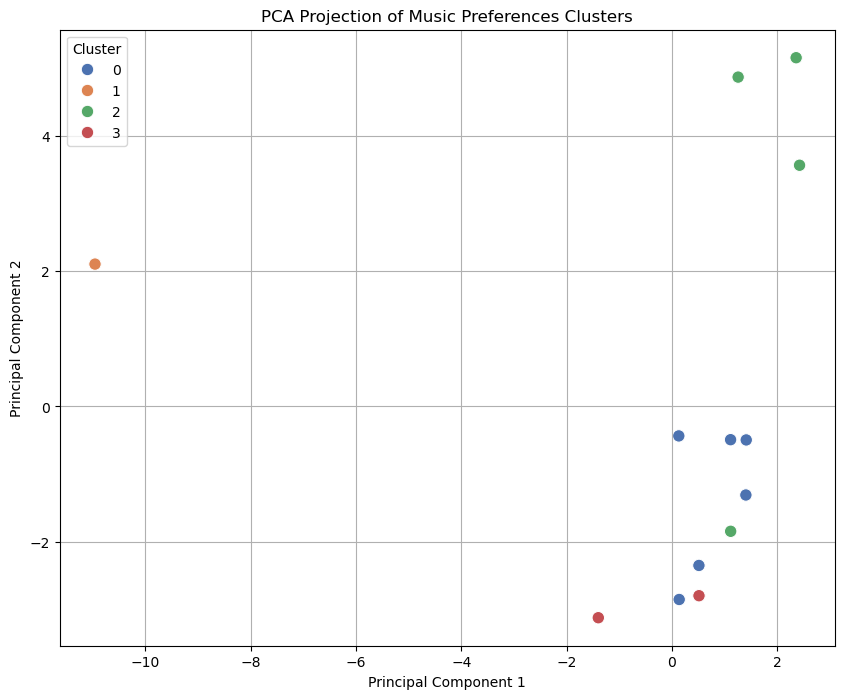

In [733]:
# scales the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

# applies kmeans
kmeans = KMeans(n_clusters=4, random_state=42)  # you can tweak the number of clusters later
clusters = kmeans.fit_predict(X_scaled)

# adds cluster labels
df_clustering['cluster'] = clusters

# pca
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

# plots pca
plt.figure(figsize=(10,8))
sns.scatterplot(x=pca_coords[:, 0], y=pca_coords[:, 1], hue=df_clustering['cluster'], palette='deep', s=80)
plt.title('PCA Projection of Music Preferences Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

In [734]:
# groups the dataset by cluster and find the mean value for each feature
cluster_summary = df_clustering.groupby('cluster').mean().round(2)

print(cluster_summary)

         What genres do you usually listen to on the regular?_Country  \
cluster                                                                 
0                                                     0.17              
1                                                     1.00              
2                                                     0.00              
3                                                     1.00              

         What genres do you usually listen to on the regular?_EDM / house  \
cluster                                                                     
0                                                     0.17                  
1                                                     0.00                  
2                                                     1.00                  
3                                                     0.00                  

         What genres do you usually listen to on the regular?_Hip-Hop / Rap  \
cluster            

In [735]:
simulated_data = []
n_simulations = 30
cluster_sizes = df_clustering['cluster'].value_counts().sort_index()
cluster_probs = cluster_sizes / cluster_sizes.sum()


for _ in range(n_simulations):
    # randomly pick a cluster also this is weighted based on how heavy the clusters are
    chosen_cluster = np.random.choice(cluster_summary.index, p=cluster_probs)

    # generate a row based on that cluster's traits
    row = {}
    cluster_traits = cluster_summary.loc[chosen_cluster]

    # for binary features (genres, party music, etc.)
    for feature in cluster_traits.index:
        if feature.startswith('What genres do you usually listen to on the regular?') or feature.startswith(
            'What music do you listen to while studying') or feature.startswith(
                'What genre are you most likely to put on aux at a function') or feature.startswith(
                    '  When do you mostly listen to music?  '):
            # probabilistic yes/no based on real cluster average
            prob = cluster_traits[feature]
            row[feature] = np.random.binomial(1, prob)
    
    # for numeric features like energy level
    if 'On a scale from 1–10, how high-energy is your music taste?  ' in cluster_traits.index:
        mean_energy = cluster_traits['On a scale from 1–10, how high-energy is your music taste?  ']
        row['On a scale from 1–10, how high-energy is your music taste?  '] = np.clip(np.random.normal(mean_energy, 1), 1, 10).round()

    row['source'] = 'simulated'
    simulated_data.append(row)

simulated_df = pd.DataFrame(simulated_data)
simulated_df

,What genres do you usually listen to on the regular?_Country,What genres do you usually listen to on the regular?_EDM / house,What genres do you usually listen to on the regular?_Hip-Hop / Rap,What genres do you usually listen to on the regular?_Indie/ alternative,What genres do you usually listen to on the regular?_Jazz,What genres do you usually listen to on the regular?_K-pop,What genres do you usually listen to on the regular?_Latin,What genres do you usually listen to on the regular?_Lo-fi,What genres do you usually listen to on the regular?_Pop,What genres do you usually listen to on the regular?_R&B,...,When do you mostly listen to music? _When I'm baking,When do you mostly listen to music? _When I’m sad,When do you mostly listen to music? _While gaming,When do you mostly listen to music? _While studying,When do you mostly listen to music? _While walking to class,When do you mostly listen to music? _With friends / parties,When do you mostly listen to music? _crocheting,When do you mostly listen to music? _or doing another hobby,"On a scale from 1–10, how high-energy is your music taste?",source
0,1,1,1,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,6.0,simulated
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,5.0,simulated
2,0,1,1,1,0,0,0,1,1,1,...,0,1,0,1,1,1,0,0,7.0,simulated
3,0,0,1,1,0,0,0,0,1,1,...,0,0,0,1,1,0,0,0,6.0,simulated
4,0,1,1,1,1,0,0,0,0,1,...,0,1,0,1,1,1,0,0,6.0,simulated
5,0,1,1,1,0,1,0,1,0,0,...,0,1,1,1,1,1,0,0,7.0,simulated
6,1,0,1,1,1,1,0,1,1,1,...,1,1,0,0,1,0,1,1,5.0,simulated
7,0,1,1,1,0,0,0,0,1,1,...,0,1,1,1,1,1,0,0,5.0,simulated
8,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,1,1,0,0,6.0,simulated
9,1,0,1,1,0,0,0,0,1,1,...,0,0,0,1,1,0,0,0,5.0,simulated


c:\Users\mcahi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mcahi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mcahi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mcahi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

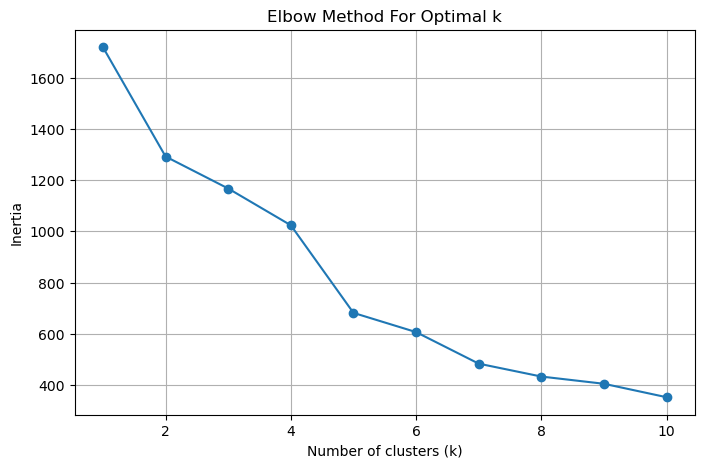

In [736]:
final_df = pd.concat([df, simulated_df], ignore_index=True)  # df = real responses
final_df = final_df.fillna(0)

features_to_cluster = [
    col for col in final_df.columns 
    if col not in ['source', 'cluster'] # doesn't include label or cluster number
]

X = final_df[features_to_cluster]

# select only numeric features
X = final_df.select_dtypes(include=[np.number])

# drop non-feature columns (cluster IDs if they exist)
X = X.drop(columns=['cluster', 'new_cluster'], errors='ignore')

# scale the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []  # list to store inertia values

k_range = range(1, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # save the inertia for this k

# Now plot
plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

c:\Users\mcahi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


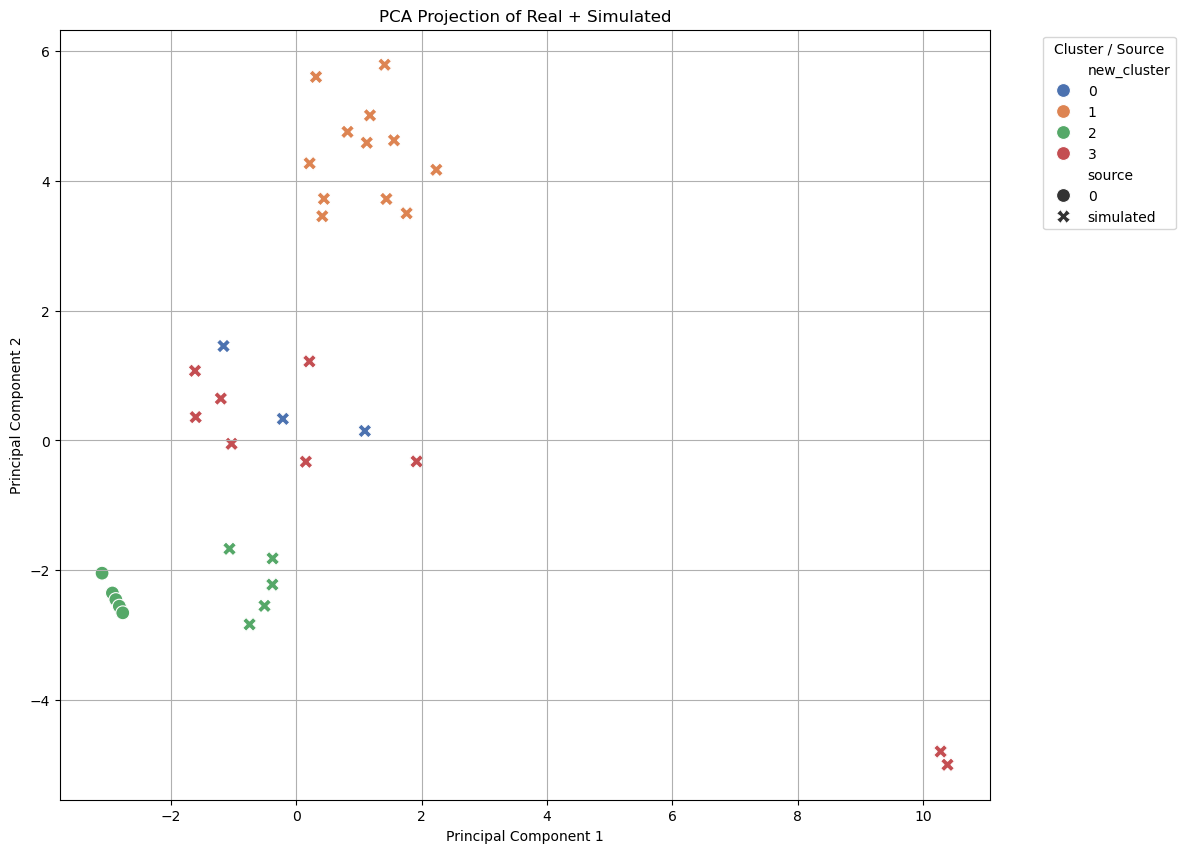

In [737]:
# cluster the new full dataset
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# add new cluster labels
final_df['new_cluster'] = clusters

# pca for visualization
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

# plot PCA Clustering
plt.figure(figsize=(12,10))
sns.scatterplot(
    x=pca_coords[:, 0],
    y=pca_coords[:, 1],
    hue=final_df['new_cluster'],
    style=final_df['source'],  # Different markers for real vs simulated
    palette='deep',
    s=100
)
plt.title('PCA Projection of Real + Simulated')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title="Cluster / Source", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [738]:
# group the dataset by cluster and find the mean value for each feature
cluster_summary = final_df.groupby('new_cluster').mean(numeric_only=True).round(2)

cluster_summary

,"On a scale from 1–10, how high-energy is your music taste?",What genres do you usually listen to on the regular?_Country,What genres do you usually listen to on the regular?_EDM / house,What genres do you usually listen to on the regular?_Hip-Hop / Rap,What genres do you usually listen to on the regular?_Indie/ alternative,What genres do you usually listen to on the regular?_Jazz,What genres do you usually listen to on the regular?_K-pop,What genres do you usually listen to on the regular?_Latin,What genres do you usually listen to on the regular?_Lo-fi,What genres do you usually listen to on the regular?_Pop,...,When do you mostly listen to music? _In the morning,When do you mostly listen to music? _Late at night,When do you mostly listen to music? _When I'm baking,When do you mostly listen to music? _When I’m sad,When do you mostly listen to music? _While gaming,When do you mostly listen to music? _While studying,When do you mostly listen to music? _While walking to class,When do you mostly listen to music? _With friends / parties,When do you mostly listen to music? _crocheting,When do you mostly listen to music? _or doing another hobby
new_cluster,,,,,,,,,,,,,,,,,,,,,
0,5.67,0.33,0.0,1.00,1.00,0.00,0.00,0.0,0.00,0.67,...,0.00,0.00,0.0,0.00,0.00,1.00,1.00,0.33,0.0,0.0
1,6.58,0.00,1.0,1.00,0.83,0.17,0.25,0.0,0.42,0.75,...,0.83,0.67,0.0,0.92,0.58,0.83,0.67,0.92,0.0,0.0
2,5.67,0.28,0.0,0.17,0.00,0.00,0.00,0.0,0.00,0.28,...,0.00,0.00,0.0,0.00,0.00,0.00,0.17,0.00,0.0,0.0
3,5.10,0.60,0.1,1.00,0.50,0.30,0.30,0.4,0.30,0.70,...,0.00,0.50,0.3,0.30,0.00,0.60,0.50,0.70,0.3,0.3


In [739]:
genre_cols = [col for col in cluster_summary.columns if col.startswith('What genres do you usually listen to on the regular?')]

cluster_summary_genre = cluster_summary[genre_cols]
cluster_summary_genre

,What genres do you usually listen to on the regular?_Country,What genres do you usually listen to on the regular?_EDM / house,What genres do you usually listen to on the regular?_Hip-Hop / Rap,What genres do you usually listen to on the regular?_Indie/ alternative,What genres do you usually listen to on the regular?_Jazz,What genres do you usually listen to on the regular?_K-pop,What genres do you usually listen to on the regular?_Latin,What genres do you usually listen to on the regular?_Lo-fi,What genres do you usually listen to on the regular?_Pop,What genres do you usually listen to on the regular?_R&B,What genres do you usually listen to on the regular?_Rock,What genres do you usually listen to on the regular?_classical
new_cluster,,,,,,,,,,,,
0,0.33,0.0,1.00,1.00,0.00,0.00,0.0,0.00,0.67,1.0,0.67,0.00
1,0.00,1.0,1.00,0.83,0.17,0.25,0.0,0.42,0.75,0.5,0.33,0.00
2,0.28,0.0,0.17,0.00,0.00,0.00,0.0,0.00,0.28,0.0,0.17,0.11
3,0.60,0.1,1.00,0.50,0.30,0.30,0.4,0.30,0.70,0.9,0.50,0.30


In [740]:
top_genres_per_cluster = {}

for cluster_id, row in cluster_summary_genre.iterrows():
    # Sort genres in descending order for this cluster
    sorted_genres = row.sort_values(ascending=False)

    # Pick the top 2 (or top 3) genres
    top_genres = sorted_genres.head(1).index.tolist()

    # Save it
    top_genres_per_cluster[cluster_id] = top_genres

for cluster, genres in top_genres_per_cluster.items():
    print(f"Cluster {cluster}: Top Genres -> {genres}")


Cluster 0: Top Genres -> ['What genres do you usually listen to on the regular?_Hip-Hop / Rap']
Cluster 1: Top Genres -> ['What genres do you usually listen to on the regular?_EDM / house']
Cluster 2: Top Genres -> ['What genres do you usually listen to on the regular?_Country']
Cluster 3: Top Genres -> ['What genres do you usually listen to on the regular?_Hip-Hop / Rap']
